This kernel is a complete guide on training neural net for sentiment analysis . From loading pretrained embedding to test the model performance on User's input. Different pretrained embeddings (Fasttext, Glove,..) will be used in order to compare their performance.    

After running this kernel, we can play with model and see the result like this

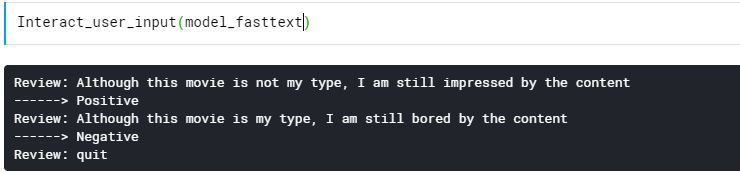

With my best effort, I hope you will find this guide is comfortable and useful.

Thank you

<a class="anchor" id="0.1"></a>

# **Table of Contents**


1.	[Processing dataset](#1)
2.  [Pretrained word embedding](#2)
3.  [Building model pipeline](#3)
4.  [Training model with Fasttext embedding](#4)
5.  [Training model with Glove embedding](#5)
6.  [Interact with User's input review](#6)


In [ ]:
import numpy as np
import pandas as pd
import io
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs
from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import tensorflow as tf  # we use both tensorflow and pytorch (pytorch for main part) , tensorflow for tokenizer

torch.manual_seed(42);

# **1. Processing dataset** <a class="anchor" id="1"></a>

[Go back to table of contents](#0.1)

In [ ]:
# Read data
df = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head(3)

In [ ]:
# Convert sentiment columns to numerical values
df.sentiment = df.sentiment.apply(lambda x: 1 if x=='positive' else 0)
## Cross validation 
# create new column "kfold" and assign a random value
df['kfold'] = -1
# Random the rows of data
df = df.sample(frac=1).reset_index(drop=True)
# get label
y = df.sentiment.values
# initialize kfold
kf = model_selection.StratifiedKFold(n_splits=5)
# fill the new values to kfold column
for fold, (train_, valid_) in enumerate(kf.split(X=df, y=y)):
    df.loc[valid_, 'kfold'] = fold
df.head(3)

# **2. Pretrained word embedding** <a class="anchor" id="2"></a>

[Go back to table of contents](#0.1)

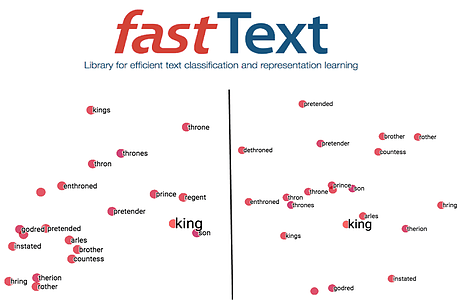

Fasttext is a word embedding development by Facebook released in 2016.
FastText improves on Word2Vec by taking word parts into account, enables training of embeddings on smaller datasets and generalization to unknown words.

The full version of fasttext can be found here : https://fasttext.cc/docs/en/english-vectors.html 

Due to the size of memory, ( the full version will be around 13GB RAM after loading), so I use the mini version of fasttext.  If you use the full version just replace the path and everything will be running normally on local machine (RAM atleast 15GB to run smoothly)

In [ ]:
#load fasttext embeddings
print('loading word embeddings...')
fasttext_embedding = {}
f = codecs.open('../input/fasttext/wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    fasttext_embedding[word] = coefs
f.close()

In [ ]:
# Different embedding version will have different dimension. 
# we have to check the dimension of this fasttext embedding version
# Because this step is important,coz it relate to the later step when we define the dimension for embedding matrix
fasttext_embedding['hello'].shape

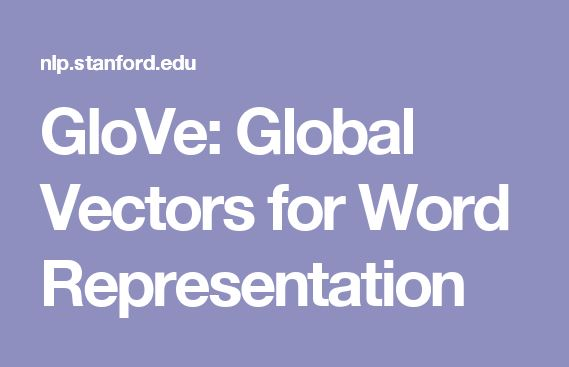

Glove is a word embedding development by Standford released in 2014.
GloVe use the frequency of co-occurrences as vital information and should not be “wasted ”as additional training examples. GloVe builds word embeddings in a way that a combination of word vectors relates directly to the probability of these words’ co-occurrence in the corpus.


In [ ]:
# Load Standford Glove embedding.
glove = pd.read_csv('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

# Check check the dimension of this fasttext embedding version
glove_embedding['hello'].shape

# **3. Building model pipeline** <a class="anchor" id="3"></a>

[Go back to table of contents](#0.1)


### Dataset class

First we need to create a Dataset class, take input in numpy array(embedding matrix) and return torch tensor output datatype 

In [ ]:

class IMDBDataset:
    def __init__(self, reviews, targets):
        """
        Argument:
        reviews: a numpy array
        targets: a vector array
        
        Return xtrain and ylabel in torch tensor datatype, stored in dictionary format
        """
        self.reviews = reviews
        self.target = targets
    
    def __len__(self):
        # return length of dataset
        return len(self.reviews)
    
    def __getitem__(self, index):
        # given an idex (item), return review and target of that index in torch tensor
        review = torch.tensor(self.reviews[index,:], dtype = torch.long)
        target = torch.tensor(self.target[index], dtype = torch.float)
        
        return {'review': review,
                'target': target}

**Now we move on to build a model class. Before that, there's something to remembe**r:

* The input feed to model is served as embedding matrix (each row corresponding to an embedding vector of a word)
* Number of words (for entire dataset) = number of row in embeddng matrix 
* Dimension of embedding is the num of columns in matrix, = dimention of pretrained embedding (fasttext, glove,..in case we use pretrained embedding). 
* Pretrained embeddings have several versions with different dimension so we should check the dimension before set dimension to model.
* In case we use pretrainde embedding (this kernel), we will not do gadient calculation on these embedding (required grads = False)
* In case we train embedding from scratch, we will treat embedding matrix as weight parameter and training on them (required grads = True)


In [ ]:
class LSTM(nn.Module):
    def __init__(self, embedding_matrix):
        """
        Given embedding_matrix: numpy array with vector for all words
        return prediction ( in torch tensor format)
        """
        super(LSTM, self).__init__()
        # Number of words = number of rows in embedding matrix
        num_words = embedding_matrix.shape[0]
        # Dimension of embedding is num of columns in the matrix
        embedding_dim = embedding_matrix.shape[1]
        # Define an input embedding layer
        self.embedding = nn.Embedding(
                                      num_embeddings=num_words,
                                      embedding_dim=embedding_dim)
        # Embedding matrix actually is collection of parameter
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype = torch.float32))
        # Because we use pretrained embedding (GLove, Fastext,etc) so we turn off requires_grad-meaning we do not train gradient on embedding weight
        self.embedding.weight.requires_grad = False
        # LSTM with hidden_size = 128
        self.lstm = nn.LSTM(
                            embedding_dim, 
                            128,
                            bidirectional=True,
                            batch_first=True,
                             )
        # Input(512) because we use bi-directional LSTM ==> hidden_size*2 + maxpooling **2  = 128*4 = 512, will be explained more on forward method
        self.out = nn.Linear(512, 1)
    def forward(self, x):
        # pass input (tokens) through embedding layer
        x = self.embedding(x)
        # fit embedding to LSTM
        hidden, _ = self.lstm(x)
        # apply mean and max pooling on lstm output
        avg_pool= torch.mean(hidden, 1)
        max_pool, index_max_pool = torch.max(hidden, 1)
        # concat avg_pool and max_pool ( so we have 256 size, also because this is bidirectional ==> 256*2 = 512)
        out = torch.cat((avg_pool, max_pool), 1)
        # fit out to self.out to conduct dimensionality reduction from 512 to 1
        out = self.out(out)
        # return output
        return out

After buidling the model class, we move to create train and evaluate function

In [ ]:
def train(data_loader, model, optimizer, device):
    """
    this is model training for one epoch
    data_loader:  this is torch dataloader, just like dataset but in torch and devide into batches
    model : lstm
    optimizer : torch optimizer : adam
    device:  cuda or cpu
    """
    # set model to training mode
    model.train()
    # go through batches of data in data loader
    for data in data_loader:
        reviews = data['review']
        targets = data['target']
        # move the data to device that we want to use
        reviews = reviews.to(device, dtype = torch.long)
        targets = targets.to(device, dtype = torch.float)
        # clear the gradient
        optimizer.zero_grad()
        # make prediction from model
        predictions = model(reviews)
        # caculate the losses
        loss = nn.BCEWithLogitsLoss()(predictions, targets.view(-1,1))
        # backprob
        loss.backward()
        #single optimization step
        optimizer.step()

In [ ]:
def evaluate(data_loader, model, device):
    final_predictions = []
    final_targets = []
    model.eval()
    # turn off gradient calculation
    with torch.no_grad():
        for data in data_loader:
            reviews = data['review']
            targets = data['target']
            reviews = reviews.to(device, dtype = torch.long)
            targets = targets.to(device, dtype=torch.float)
            # make prediction
            predictions = model(reviews)
            # move prediction and target to cpu
            predictions = predictions.cpu().numpy().tolist()
            targets = data['target'].cpu().numpy().tolist()
            # add predictions to final_prediction
            final_predictions.extend(predictions)
            final_targets.extend(targets)
    return final_predictions, final_targets

## Config

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 5

In [ ]:
def create_embedding_matrix(word_index, embedding_dict=None, d_model=100):
    """
     this function create the embedding matrix save in numpy array
    :param word_index: a dictionary with word: index_value
    :param embedding_dict: a dict with word embedding
    :d_model: the dimension of word pretrained embedding, here I just set to 100, we will define again
    :return a numpy array with embedding vectors for all known words
    """
    embedding_matrix = np.zeros((len(word_index) + 1, d_model))
    ## loop over all the words
    for word, index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index] = embedding_dict[word]
    return embedding_matrix

After we building some helper function, now is time to running the model. 
The entire workflow will be as following steps:

==> **Step1**: Creating a tokenizer function to convert sentences of dataset to token index
After converting we'll have a dictionary contain word and its index. We feed it to creating an embedding matrix

==> **Step2**: Cross validation of dataset to devide into train_df and valid_df

==> **Step3**: Applying tokenizer pad_sequence to token index to ensure all sentence has the same vector dimension ( example: the sentence with 10 words will have longer vector dimension then the sentence with 2 words, using pad_sequence to ensure the same length, The length is set to a fixed number)

I use tokenizer from tensorflow 2 because of its convenience in pad_sequence. you can use tokenizer and pad_sequence from pytorch too but I felt it's quite longer implementation. If you would like to use pytorch pad_sequence, You can visit my other work that I have used pytorch
https://www.kaggle.com/tientd95/understanding-attention-in-neural-network

**Remember after zero_padding, the result would return in numpy array datatype**

==> **Step4**: Initialize Dataset class, actually this step is just convet the numpy array (in Step3) to torch tensor 

==> **Step5**: We load the Dataset which created in step4 to Pytorch DataLoader in order to devide the dataset to batches

==> **Step6**: Till now, we have almost necessary components to start training. Calling model, optimizer, send model to device and start running

# **4. Training model with Fasttext embedding** <a class="anchor" id="4"></a>

[Go back to table of contents](#0.1)


Remember fasttext embedding version in this kernel is 300,  So we set d_model =300

In [ ]:
# STEP 1: Tokenization
# use tf.keras for tokenization,  
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.review.values.tolist())

In [ ]:
print('Load fasttext embedding')
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_dict=fasttext_embedding, d_model=300)

# I just run 1 fold to reduce the time. You can try more fold to get better generalization
for fold in range(1):
    # STEP 2: cross validation
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)
    
    # STEP 3: pad sequence
    xtrain = tokenizer.texts_to_sequences(train_df.review.values)
    xtest = tokenizer.texts_to_sequences(valid_df.review.values)
    
    # zero padding
    xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain, maxlen=MAX_LEN)
    xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest, maxlen=MAX_LEN)
    
    # STEP 4: initialize dataset class for training
    train_dataset = IMDBDataset(reviews=xtrain, targets=train_df.sentiment.values)
    
    # STEP 5: Load dataset to Pytorch DataLoader
    # after we have train_dataset, we create a torch dataloader to load train_dataset class based on specified batch_size
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = TRAIN_BATCH_SIZE, num_workers=2)
    # initialize dataset class for validation
    valid_dataset = IMDBDataset(reviews=xtest, targets=valid_df.sentiment.values)
    valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = VALID_BATCH_SIZE, num_workers=1)
    
    # STEP 6: Running 
    device = torch.device('cuda')
    # feed embedding matrix to lstm
    model_fasttext = LSTM(embedding_matrix)
    # set model to cuda device
    model_fasttext.to(device)
    # initialize Adam optimizer
    optimizer = torch.optim.Adam(model_fasttext.parameters(), lr=1e-3)
    
    print('training model')
   
    for epoch in range(EPOCHS):
        #train one epoch
        train(train_data_loader, model_fasttext, optimizer, device)
        #validate
        outputs, targets = evaluate(valid_data_loader, model_fasttext, device)
        # threshold
        outputs = np.array(outputs) >= 0.5
        # calculate accuracy
        accuracy = metrics.accuracy_score(targets, outputs)
        print(f'FOLD:{fold}, epoch: {epoch}, accuracy_score: {accuracy}')

# **5. Training model with Glove embedding** <a class="anchor" id="5"></a>

[Go back to table of contents](#0.1)


Remember Glove embedding version in this kernel is 100,  So we set d_model =100

In [ ]:
print('Load Glove embedding')
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_dict=glove_embedding, d_model=100)

for fold in range(1):
    # STEP 2: cross validation
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)
    
    # STEP 3: pad sequence
    xtrain = tokenizer.texts_to_sequences(train_df.review.values)
    xtest = tokenizer.texts_to_sequences(valid_df.review.values)
    
    # zero padding
    xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain, maxlen=MAX_LEN)
    xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest, maxlen=MAX_LEN)
    
    # STEP 4: initialize dataset class for training
    train_dataset = IMDBDataset(reviews=xtrain, targets=train_df.sentiment.values)
    
    # STEP 5: Load dataset to Pytorch DataLoader
    # after we have train_dataset, we create a torch dataloader to load train_dataset class based on specified batch_size
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = TRAIN_BATCH_SIZE, num_workers=2)
    # initialize dataset class for validation
    valid_dataset = IMDBDataset(reviews=xtest, targets=valid_df.sentiment.values)
    valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = VALID_BATCH_SIZE, num_workers=1)
    
    # STEP 6: Running 
    device = torch.device('cuda')
    # feed embedding matrix to lstm
    model_glove = LSTM(embedding_matrix)
    # set model to cuda device
    model_glove.to(device)
    # initialize Adam optimizer
    optimizer = torch.optim.Adam(model_glove.parameters(), lr=1e-3)
    
    print('training model')
   
    for epoch in range(EPOCHS):
        #train one epoch
        train(train_data_loader, model_glove, optimizer, device)
        #validate
        outputs, targets = evaluate(valid_data_loader, model_glove, device)
        # threshold
        outputs = np.array(outputs) >= 0.5
        # calculate accuracy
        accuracy = metrics.accuracy_score(targets, outputs)
        print(f'FOLD:{fold}, epoch: {epoch}, accuracy_score: {accuracy}')

# **6. Interact with User's input review** <a class="anchor" id="6"></a>

[Go back to table of contents](#0.1)

Now it's time to test model by entering any review we can think and see the model reaction

In [ ]:
def Interact_user_input(model):
    '''
    model: trained model : fasttext model or glove model
    '''
    model.eval()
    
    sentence = ''
    while True:
        try:
            sentence = input('Review: ')
            if sentence in ['q','quit']: 
                break
            sentence = np.array([sentence])
            sentence_token = tokenizer.texts_to_sequences(sentence)
            sentence_token = tf.keras.preprocessing.sequence.pad_sequences(sentence_token, maxlen = MAX_LEN)
            sentence_train = torch.tensor(sentence_token, dtype = torch.long).to(device, dtype = torch.long)
            predict = model(sentence_train)
            if predict.item() > 0.5:
                print('------> Positive')
            else:
                print('------> Negative')
        except KeyError:
            print('please enter again')
    

## Enter reviews and test the result

In [ ]:
Interact_user_input(model_fasttext)